### Dependencies   

In [537]:

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.time import BaseScheduler
from mesa.space import MultiGrid
import numpy as np
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule, TextElement
from mesa.datacollection import DataCollector
import random
import math
import matplotlib.pyplot as plt
import pandas as pd

### Functions used to calculate required bikes and vans
#### Takes the total number of parcels, the capcities of bikes and vans, and the ration of vans to bikes as arguments to calcutate this.

In [2]:


def find_bikes_req(num_boxes,ratio_v_b,v_parcels,b_parcels):
    b_req =math.ceil(((num_boxes)/(b_parcels+(v_parcels*ratio_v_b))))
    return b_req

def find_bikes_dec(num_boxes,ratio_v_b,v_parcels,b_parcels):
    b_req =(((num_boxes)/(b_parcels+(v_parcels*ratio_v_b))))
    return b_req

def find_vans_req(num_boxes,ratio_v_b,v_parcels,b_parcels):
    b_req = find_bikes_dec(num_boxes,ratio_v_b,v_parcels,b_parcels)
    v_req= math.ceil(b_req*ratio_v_b)
    return v_req



In [420]:
#source:Sven Marnach on Stack Overflow
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

### Agent Types: 
#### These are the four types in this model:
#### Curbs: The area on a street which may be a parking space/ loading location. This space can be occupied by bikes or vans.
#### Buildings: These are the destination for the parcels, their purpose is to allocate appropriate parking for agents to deliver to them.
#### Bikes: Are a cargo e-bike agent
#### Vans: are a van agent

### Curbs

In [473]:
# this agent is a potential parking location at the curb            
class curb_border(Agent):
    def __init__(self, pos, model,prob_av):
        super().__init__(pos, model)
        self.prob=prob_av
        self.dist_calc={}
        self.deliverd_by_b=[]
        self.deliverd_by_v=[]
# A list containing the parcels that can be delivered. 
# This list is appended by the building agent depending on the distance a delivery person is willing to walk        
        self.destination_for=[]
# This list is for bikes as they have different conditions to park    
        self.bike_del=[]
#chance is the probability of a vacant space for parking. 
#Vans can only park on a vacant space. Bikes will park anywhere.
        chance=random.randint(0, self.prob)
        if chance==0:
            self.available = True
        else:
            self.available = False     

    def step(self):
        #print(self.dist_calc)
        return

### Buildings

In [434]:
#building agent/ delivery desitinations       
class building(Agent):
    def __init__(self, pos, model,boxes):
        super().__init__(pos, model)
# A list of boxes to be delivered. This is used to inform the curb agent.
        self.waiting_for=boxes
# A list of curb agent locations that are in range.
        self.in_range=[]
# A list of curb agent locations that are in range that can be used to complete a delivery for vans
        self.loading_bays = []
        self.dist_dest=[]
        self.pos=pos
        x, y = self.pos
#how far a delivery person is willing to park/walk        
        self.vision=3
#is used to makes sure that buildings perform all steps just once at the begining of the run. see step.    
        self.val=0
# This can be used to control which buildings can be desitinations
        chance=0
        
        if chance==0:
            self.destination = True
        else:
            self.destination = False
            
#insert positions as argument and returns the agent in the cell that is the curb    
    def get_curb(self,bib):
            
            for i in self.model.grid.get_cell_list_contents([bib]):
                if type(i) is curb_border:
                    return i
    
#this function finds the curbs within range    
    def distribute(self):         
        for i in self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision):
            
#keeping values equal to those on grid. Currently hard coded.           
            if i[0]<29  and i[1]==1:
                self.in_range.append(self.get_curb(i))
#checks if curbs that are in range are availble for parking for vans        
        for c in self.in_range:
            if c. available == True:
                self.loading_bays.append(c)                                    
#caclulates distance parked away from delivery
        

        for p in self.loading_bays:
            p.destination_for=self.waiting_for+p.destination_for
            #waiting for is a list
        for p in self.loading_bays:    
            for i in self.waiting_for:
                p.dist_calc.update({i: round(distance(p.pos, self.pos))}) 
            
            

    

            
            
#makes list for areas where bikes can deliver. In this model thats any curb side            
    def distribute_for_bike(self):
        neighborz = []
        x, y = self.pos
        for dx in [0]:
            for dy in [-1]:
                neighborz.append((x+dx, y+dy))        
        self.get_curb(neighborz[0]).bike_del= self.waiting_for+self.get_curb(neighborz[0]).bike_del     
        
        #agent below given as bike dest              
    

#makes all allocations once at the begining    
    def step(self):
        #print("im building",self.pos,"im waiting for",self.waiting_for)
        if self.val==0:
            self.distribute()
            self.distribute_for_bike()
            self.val=self.val+1

            
            
#building agent that is not a delivery destination     
class building2(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)

# This can be used to control which buildings can be desitinations in this case it is not
        chance=1
        
        if chance==0:
            self.destination = True
        else:
            self.destination = False
            
        
  


### Bikes

In [487]:
class bikes(Agent):
    """ An ebike agent """
    
    def __init__(self, unique_id, model,boxes):
        super().__init__(unique_id, model)
        #state: 1= drving ,0= parked/delivering 
        self.state = 1
        self.parcels=boxes
        self.storage=[]
        self.delivered_b=[]
        self.wait_time=120
        self.laps=0
        self.spm=0
        self.tot_spm_made=0
        self.tot_spm_possible=0
#function for movement along road    
    def move(self):
        neighbors = []
        x, y = self.pos
        for dx in [1]:
            for dy in [0]:
                neighbors.append((x+dx, y+dy))
        possible_steps = neighbors
        if possible_steps[0][0]<30: #makes sure the check is performed within the correct index
            #makes sure the cell ahead is empty before moving into it
            if len(self.model.grid.get_cell_list_contents([possible_steps[0]]))==0:
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
                self.spm=1
                self.tot_spm_made+=1
                self.tot_spm_possible+=1
            else:
                self.spm=0
                self.tot_spm_possible+=1
                
        else:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

#gets curb agent in cell    
    def get_curb(self,bib):
            
            for i in self.model.grid.get_cell_list_contents([bib]):
                if type(i) is curb_border:
                    return i

#function to park the bike    
    def park(self):
               
        neighbors = []
        x, y = self.pos      
        for dy in [1]:        
            for dx in [0]:                
                neighbors.append((x+dx, y+dy))        
        if self.state==1:
            self.model.grid.move_agent(self, neighbors[0])
            self.state=0

#function to check if arrived at a destination by comparing own parcel list with that of curb    
    def check_arrival(self):       
        loc = []
        x, y = self.pos
        for dx in [0]:
            for dy in [1]:
                loc.append((x+dx, y+dy))       
        location=self.get_curb(loc[0])
        
        for i in self.parcels:
            for j in location.bike_del:
                if i==j:
                    self.timer=0
                    self.park()

#function to perform delivery               
    def deliver(self):
        #this is to keep track of time taken to deliver
        self.timer=self.timer+1
        #removes "delivered" parcel from list and adds it a completed delivery list for data tracking purposes
        for i in self.get_curb(self.pos).bike_del :
            for j in  self.parcels:
                if i==j:
                    self.parcels.remove(i)
                    self.delivered_b.append(i)
                    self.get_curb(self.pos).deliverd_by_b.append(i)
                    
                    
#function to depart after delivery                    
    def depart(self):
        neighbors = []
        x, y = self.pos
        for dy in [-1]: 
            for dx in [0]:
                neighbors.append((x+dx, y+dy))
        self.model.grid.move_agent(self, neighbors[0])
        #changes state back to driving 
        self.state=1
 
    def step(self):
        #print(self.parcels,self.delivered_b)
        # moves and checks if it needs to park while driving
        if self.state==1:
            self.move()
            self.check_arrival()
        # when parked completes the delivery  
        else:
            self.deliver()
            # waits x ticks before departing represent the amount of time it would take to complete a delivery
            if self.timer>self.wait_time:
                self.depart()

### Vans

In [486]:
class vans(Agent):

    
    def __init__(self, unique_id, model,boxes):
        super().__init__(unique_id, model)
        #state: 1= drving ,0= parked/delivering 
        self.state = 1
        self.parcels=boxes
        self.storage=[]
        self.delivered_v=[]
        self.wait_time=120
        self.laps=0
        self.spm=0
        self.tot_spm_made=0
        self.tot_spm_possible=0
    
    #function for movement along road    
    def move(self):
        neighbors = []
        x, y = self.pos
        for dx in [1]:
            for dy in [0]:
                neighbors.append((x+dx, y+dy))
        possible_steps = neighbors
        if possible_steps[0][0]<30: #makes sure the check is performed within the correct index
            #makes sure the cell ahead is empty before moving into it
            if len(self.model.grid.get_cell_list_contents([possible_steps[0]]))==0:
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
                self.spm=1
                self.tot_spm_made+=1
                self.tot_spm_possible+=1
            else:
                self.spm=0
                self.tot_spm_possible+=1
        else:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
 
    #gets curb agent in cell    
    def get_curb(self,bib):
            
            for i in self.model.grid.get_cell_list_contents([bib]):
                if type(i) is curb_border:
                    return i
    #parks the van
    def park(self):
        if self.stoppage==5:
            neighbors = []
            x, y = self.pos      
            for dy in [1]:        
                for dx in [0]:                
                    neighbors.append((x+dx, y+dy))        
            if self.state==2:
                self.model.grid.move_agent(self, neighbors[0])
                self.state=0
                self.deliver()
                
        else:
            self.state=2
        
    
    #function to check if arrived at a destination by comparing own parcel list with that of curb
    def check_arrival(self):
        loc = []
        x, y = self.pos
        
        for dx in [0]:
            for dy in [1]:
                loc.append((x+dx, y+dy))       
        location=self.get_curb(loc[0])
        for i in self.parcels:
            for j in location.destination_for:
                #makes sure no other van in the parking
                if i==j and len(self.model.grid.get_cell_list_contents([location.pos]))==1:
                    self.stoppage=0
                    self.timer=0
                    self.park()
    
    #function to perform delivery               
    def deliver(self):
        
        for i in self.get_curb(self.pos).destination_for :
            for j in  self.parcels:
                if i==j:
                    self.parcels.remove(i)
                    self.delivered_v.append(i)
                    self.get_curb(self.pos).deliverd_by_v.append(i)
                    self.wait_time=self.wait_time+(self.get_curb(self.pos).dist_calc[i]*6)
   
 #function to depart after delivery                    
    def depart(self):
        neighbors = []
        x, y = self.pos
        for dy in [-1]: 
            for dx in [0]:
                neighbors.append((x+dx, y+dy))
        self.model.grid.move_agent(self, neighbors[0])
        #changes state back to driving 
        self.state=1

    def step(self):
        #print(self.pos)
     # moves and checks if it needs to park while driving
        if self.state==1:
            self.move()
            self.check_arrival()
        # waits x ticks before departing represent the amount of time it would take to complete a delivery   
        elif self.state==0:
            #print("my stoppage is ",self.stoppage)
            self.timer=self.timer+1
            if self.timer>self.wait_time:
                self.depart()
        elif self.state==2:
            self.stoppage+=1
            self.park()   

### Cars 

In [485]:
class cars(Agent):

    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #state: 1= drving ,0= parked
        self.state = 1
        self.timer=0
        self.wait_time=random.randint(5, 500)
        self.parcels=["JFT"]
        self.laps=4
        self.spm=0
        self.tot_spm_made=0
        self.tot_spm_possible=0
    
    #function for movement along road    
    def move(self):
        neighbors = []
        x, y = self.pos
        for dx in [1]:
            for dy in [0]:
                neighbors.append((x+dx, y+dy))
        possible_steps = neighbors
        if possible_steps[0][0]<30: #makes sure the check is performed within the correct index
            #makes sure the cell ahead is empty before moving into it
            if len(self.model.grid.get_cell_list_contents([possible_steps[0]]))==0:
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
                self.spm=1
                self.tot_spm_made+=1
                self.tot_spm_possible+=1
            else:
                self.spm=0
                self.tot_spm_possible+=1
        else:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
 
    #gets curb agent in cell    
    def get_curb(self,bib):
            
            for i in self.model.grid.get_cell_list_contents([bib]):
                if type(i) is curb_border:
                    return i
    #parks the car
    def park(self):
        if self.stoppage==5:
            neighbors = []
            x, y = self.pos      
            for dy in [1]:        
                for dx in [0]:                
                    neighbors.append((x+dx, y+dy))        
            if self.state==2:
                self.model.grid.move_agent(self, neighbors[0])
                self.state=0
        else:
            self.state=2
        
    
    
    def check_arrival(self):
        loc = []
        randz=random.randint(0, 100)
        x, y = self.pos
        
        for dx in [0]:
            for dy in [1]:
                loc.append((x+dx, y+dy))       
        location=self.get_curb(loc[0])
        
                #makes sure no other van/car in the parking
        if  len(self.model.grid.get_cell_list_contents([location.pos]))==1 and randz==0 and location.available==True:
                self.timer=0
                self.stoppage=0
                self.park()

   
 #function to depart                     
    def depart(self):
        neighbors = []
        x, y = self.pos
        for dy in [-1]: 
            for dx in [0]:
                neighbors.append((x+dx, y+dy))
        self.model.grid.move_agent(self, neighbors[0])
        #changes state back to driving 
        self.state=1

    def step(self):
        #print(self.pos)
     # moves and checks if it needs to park while driving
        if self.state==1:
            self.move()
            self.check_arrival()
        # waits x ticks before departing represent the amount of time it would stay parked   
        elif self.state==0:
            self.timer=self.timer+1
            if self.timer>self.wait_time:
                self.depart()
        else:
            self.stoppage+=1
            self.park()

### data collection 

In [515]:
#data collection 

def comp_bike_parcels_del(model):
    parcels_del =[]
    for agent in model.schedule.agents:
        if type(agent) is curb_border:
            parcels_del.extend(agent.deliverd_by_b)
    x = len(parcels_del)
    
    return x

def comp_van_parcels_del(model):
    parcels_del =[]
    for agent in model.schedule.agents:
        if type(agent) is curb_border:
            parcels_del.extend(agent.deliverd_by_v)
    x = len(parcels_del)
    
    return x


def average_speed_cal(model):
    mvt=0
    possible_mvt=0.01
    for agent in model.schedule.agents:
        if type(agent) is bikes or type(agent) is vans or type(agent) is cars:
            possible_mvt+=1
            mvt=agent.spm+mvt
    return (mvt/possible_mvt)*12

def average_speed_cal_total(model):
    mvt=0
    possible_mvt=0.01
    for agent in model.schedule.agents:
        if type(agent) is bikes or type(agent) is vans or type(agent) is cars:
            possible_mvt=agent.tot_spm_possible+possible_mvt
            mvt=agent.tot_spm_made+mvt
    return (mvt/possible_mvt)*12


"""def average_speed_cal_total(model):
    speeds=[]
    speeds.append(average_speed_cal(model))
    
    return sum(speeds)/len(speeds)"""

'def average_speed_cal_total(model):\n    speeds=[]\n    speeds.append(average_speed_cal(model))\n    \n    return sum(speeds)/len(speeds)'

In [461]:

self.tot_spm_made=0
self.tot_spm_possible=0

5

## Model

In [510]:
#Model


class VanByke(Model):
    """A model with some number of agents."""
    
    def __init__(self,width=30, height=3, N=100,BC=5,VC=20,R=1,T=3,CSP=3):
        super().__init__()
        self.width=width
        #self.num_agents = 1
        self.Total_Parcels=N
        self.Bike_Capacity=BC
        self.Van_Capacity=VC
        self.Ratio_of_vans_to_bikes=R
        #is used to calcualte other vehicles by multiplyig the variable by the sum of vans and bikes
        self.Traffic_Level_multiplier=T
        self.Total_Bikes=find_bikes_req(self.Total_Parcels,self.Ratio_of_vans_to_bikes,self.Van_Capacity,self.Bike_Capacity)
        self.Total_Vans=find_vans_req(self.Total_Parcels,self.Ratio_of_vans_to_bikes,self.Van_Capacity,self.Bike_Capacity)
        self.Total_Cars=round(self.Traffic_Level_multiplier*(self.width/2))
        self.Parcel_list=[*range(0, self.Total_Parcels)]
        self.Parcel_list2=[*range(0, self.Total_Parcels)]
        self.Parcel_list3=[*range(0, self.Total_Parcels)]
        random.shuffle(self.Parcel_list2)
        self.grid = MultiGrid(width, height, False)
        self.place=0
        self.all_vehicles=[]
        self.schedule = RandomActivation(self)
        self.builder=[]
        self.removed_agents=[]
        self.curb_space_prob=CSP
        type_distribution = np.genfromtxt("road_map.txt")
        self.counter=0.01
        
       
        
        #create curb
        for _,x, y in self.grid.coord_iter():
            if type_distribution[x,y]==3: #3 is the chosen identifier for curb side in the txt doc
                new_spot=curb_border((x,y),self,self.curb_space_prob)
                
                self.grid.place_agent(new_spot,(x, y))
                self.schedule.add(new_spot)
        
        #create buildings
        for _,x, y in self.grid.coord_iter():
            if type_distribution[x,y]==4: #4 is the chosen identifier for buildings in the txt doc
                ### figure out how to give each building more than 1 box
                boxes=[]
                for i in range(math.ceil(len(self.Parcel_list3)/28)):
                    if len(self.Parcel_list2)>0:
                        boxes.append(self.Parcel_list2[-1])
                        self.Parcel_list2.pop()
                
                
                new_building=building((x,y),self,boxes)
                #print(self.loading_bays)
                
                
                self.grid.place_agent(new_building,(x, y))
                self.schedule.add(new_building)
                
         
        #create buildings2 these dont receive deliveries
        for _,x, y in self.grid.coord_iter():
            if type_distribution[x,y]==5: #4 is the chosen identifier for buildings in the txt doc
                ### figure out how to give each building more than 1 box
                boxes=[]
                new_building=building2((x,y),self)
                #print(self.loading_bays)
                
                
                self.grid.place_agent(new_building,(x, y))
                self.schedule.add(new_building)
                
        #create bikes 
        
        
        for i in range(self.Total_Bikes):
            nit=[]
            for l in range(self.Bike_Capacity):
                if len(self.Parcel_list)>0:
                
                    nit.append(self.Parcel_list[-1])
                    self.Parcel_list.pop()
            
            a=bikes(i, self, nit)
            
            self.all_vehicles.append(a)
        
    
    
        #create vans
        
        
        for i in range(1000,1000+self.Total_Vans):
            nit=[]
            for l in range(self.Van_Capacity):
                if len(self.Parcel_list)>0:
                
                    nit.append(self.Parcel_list[-1])
                    self.Parcel_list.pop()
            b=vans(i, self, nit)
            
            self.all_vehicles.append(b)
        
        #create cars
        
        
        for i in range(2000,2000+self.Total_Cars):
            
            b=cars(i, self)
            
            self.all_vehicles.append(b)
        
         #data
        self.datacollector = DataCollector(
            model_reporters={"Parcels Delivered by Bikes": comp_bike_parcels_del,
                             "Parcels Delivered by Vans": comp_van_parcels_del, "Average Movement Speed in Km/h":average_speed_cal,"Model-time Average Speed in Km/h":average_speed_cal_total}
            )
        
           
                   
        self.running = True
        self.datacollector.collect(self)
    
        random.shuffle(self.all_vehicles)
        
    def step(self):
        self.counter+=1
        
        
        self.schedule.step()
        
        if len(self.all_vehicles)>0 and len(self.grid.get_cell_list_contents([(0,0)]))==0:#[*range(0,2000)][self.place]%2==0:
                
                
                self.grid.place_agent(self.all_vehicles[-1],(0,0))
                self.schedule.add(self.all_vehicles[-1])
                self.all_vehicles.pop()
        
        for i in self.schedule.agents:
        #last road cell
            if i.pos == (29,0):
                
                if len(i.parcels)==0 or i.laps==1:
                    
                    self.grid._remove_agent(i.pos, i)
                    self.schedule.remove(i)
                    self.removed_agents.append(i)
                else:
                    i.laps+=1
                    self.grid._remove_agent(i.pos, i)
                    self.schedule.remove(i)
                    self.all_vehicles.insert(0,i)
                    
        
        self.datacollector.collect(self)
        #self.schedule.step()
        self.place+=1
        if len(self.removed_agents)== self.Total_Bikes+self.Total_Vans:
            self.running = False
            
          
            

In [523]:
[0.2,0.3,0.4,0.5,1,2]

[10, 20, 30, 40, 50, 60, 70]

In [359]:
def agent_portrayal(agent):
    if agent is None:
        return

    portrayal = {}

    if type(agent) is cars :
        portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5, "Color" : "#f5b342", "Layer":1,}

    if type(agent) is bikes :
        portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.35, "Color" : "#4cc279", "Layer":1,}
    
    
    
    if type(agent) is vans :
        portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5, "Color" : "grey", "Layer":1,}
      
    elif type(agent) is curb_border:
        
        portrayal = {"Shape": "rect",
                 "Filled": "true",
                "Layer": 0 , "w":1 , "h":1,}
        
        if agent.available== True:
            portrayal["Color"] = "#d1d1d1"
        else:
            portrayal["Color"] = "#b3ae8d" 
            
            
        
    elif type(agent) is building:
        
        portrayal = {"Shape": "rect",
                 "Filled": "true",
                "Layer": 0 , "w":1 , "h":1,}
        
        if agent.destination== True:
            portrayal["Color"] = "#b5865b"
        else:
            portrayal["Color"] = "grey"     
    
    elif type(agent) is building2:
        
        portrayal = {"Shape": "rect",
                 "Filled": "true",
                "Layer": 0 , "w":1 , "h":1,}
        
        if agent.destination== True:
            portrayal["Color"] = "#b5865b"
        else:
            portrayal["Color"] = "grey" 

    return portrayal



grid = CanvasGrid(agent_portrayal, 30, 3, 690,69)
model_params = {
    "height": 3,
    "width": 30,
    "N": UserSettableParameter("slider", "Total Parcels", 10, 10, 100, 10),
    "R": UserSettableParameter("slider", "Ratio of vans to bikes", 1, 0.1, 5, 0.1),
    "VC": UserSettableParameter("slider", "Van Capacity", 10, 10, 30, 5),
    "BC": UserSettableParameter("slider", "Bike Capacity", 2, 1, 8,1),
    "CSP": UserSettableParameter("slider", "Chance of parking occupation", 2, 1, 10,1),
    "T": UserSettableParameter("slider", "Traffic Level Multiplier", 2, 1, 10,1)
    
}

In [200]:
port_num=8000


In [542]:
port_num+=1

chart = ChartModule([{"Label": "Parcels Delivered by Bikes",
                      "Color": "#4cc279"},{"Label": "Parcels Delivered by Vans",
                      "Color": "grey"}],
                    data_collector_name='datacollector')

chart2 = ChartModule([{"Label": "Average Movement Speed in Km/h",
                      "Color": "red"},{"Label": "Model-time Average Speed in Km/h",
                      "Color": "black"}],
                    data_collector_name='datacollector')

server = ModularServer(VanByke,
                       [grid,chart,chart2], 
                       "VanByke Model",
                       model_params)

server.port = port_num
server.launch()


Interface starting at http://127.0.0.1:8124


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

In [475]:
from mesa.batchrunner import BatchRunner


In [526]:
fixed_params = {"width": 30,
               "height": 3}
variable_params = {"N": range(10, 80, 10),"R":[0.2,0.3,0.4,0.5,1,2],"T":range(1,6,1)}

batch_run = BatchRunner(VanByke,
                        variable_params,
                        fixed_params,
                        iterations=30,
                        max_steps=10000,
                        model_reporters={"Model-time Average Speed in Km/h":average_speed_cal_total,"Parcels Delivered by Vans":comp_van_parcels_del,"Parcels Delivered by Bikes":comp_bike_parcels_del})
batch_run.run_all()

6300it [39:19,  2.67it/s]


18it [00:04,  3.73it/s]


In [527]:
run_data = batch_run.get_model_vars_dataframe()


In [539]:
run_data


,N,R,T,Run,Model-time Average Speed in Km/h,Parcels Delivered by Bikes,Parcels Delivered by Vans,width,height
0,10,0.2,1,0,11.460538,10,0,30,3
1,10,0.2,1,1,11.699554,10,0,30,3
2,10,0.2,1,2,11.627773,10,0,30,3
3,10,0.2,1,3,11.556029,10,0,30,3
4,10,0.2,1,4,11.392315,10,0,30,3
...,...,...,...,...,...,...,...,...,...
6295,70,2.0,5,6295,9.712237,10,38,30,3
6296,70,2.0,5,6296,9.346610,10,30,30,3
6297,70,2.0,5,6297,10.095607,10,17,30,3
6298,70,2.0,5,6298,10.285267,10,23,30,3


In [530]:
run_data.to_csv('file1.csv')

In [540]:
df1=pd.read_csv('file1ed.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1aed96650>,
      dtype=object)

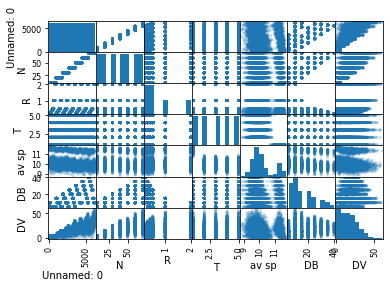

{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"reset"}
{"type":"get_st

{"type":"get_step","step":239}
{"type":"get_step","step":240}
{"type":"get_step","step":241}
{"type":"get_step","step":242}
{"type":"get_step","step":243}
{"type":"get_step","step":244}
{"type":"get_step","step":245}
{"type":"get_step","step":246}
{"type":"get_step","step":247}
{"type":"get_step","step":248}
{"type":"get_step","step":249}
{"type":"get_step","step":250}
{"type":"get_step","step":251}
{"type":"get_step","step":252}
{"type":"get_step","step":253}
{"type":"get_step","step":254}
{"type":"get_step","step":255}
{"type":"get_step","step":256}
{"type":"get_step","step":257}
{"type":"get_step","step":258}
{"type":"get_step","step":259}
{"type":"get_step","step":260}
{"type":"get_step","step":261}
{"type":"get_step","step":262}
{"type":"get_step","step":263}
{"type":"get_step","step":264}
{"type":"get_step","step":265}
{"type":"get_step","step":266}
{"type":"get_step","step":267}
{"type":"get_step","step":268}
{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":

{"type":"get_step","step":504}
{"type":"get_step","step":505}
{"type":"get_step","step":506}
{"type":"get_step","step":507}
{"type":"get_step","step":508}
{"type":"get_step","step":509}
{"type":"get_step","step":510}
{"type":"get_step","step":511}
{"type":"get_step","step":512}
{"type":"get_step","step":513}
{"type":"get_step","step":514}
{"type":"get_step","step":515}
{"type":"get_step","step":516}
{"type":"get_step","step":517}
{"type":"get_step","step":518}
{"type":"get_step","step":519}
{"type":"get_step","step":520}
{"type":"get_step","step":521}
{"type":"get_step","step":522}
{"type":"get_step","step":523}
{"type":"get_step","step":524}
{"type":"get_step","step":525}
{"type":"get_step","step":526}
{"type":"get_step","step":527}
{"type":"get_step","step":528}
{"type":"get_step","step":529}
{"type":"get_step","step":530}
{"type":"get_step","step":531}
{"type":"get_step","step":532}
{"type":"get_step","step":533}
{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":

{"type":"get_step","step":770}
{"type":"get_step","step":771}
{"type":"get_step","step":772}
{"type":"get_step","step":773}
{"type":"get_step","step":774}
{"type":"get_step","step":775}
{"type":"get_step","step":776}
{"type":"get_step","step":777}
{"type":"get_step","step":778}
{"type":"get_step","step":779}
{"type":"get_step","step":780}
{"type":"get_step","step":781}
{"type":"get_step","step":782}
{"type":"get_step","step":783}
{"type":"get_step","step":784}
{"type":"get_step","step":785}
{"type":"get_step","step":786}
{"type":"get_step","step":787}
{"type":"get_step","step":788}
{"type":"get_step","step":789}
{"type":"get_step","step":790}
{"type":"get_step","step":791}
{"type":"get_step","step":792}
{"type":"get_step","step":793}
{"type":"get_step","step":794}
{"type":"get_step","step":795}
{"type":"get_step","step":796}
{"type":"get_step","step":797}
{"type":"get_step","step":798}
{"type":"get_step","step":799}
{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":

In [541]:
pd.plotting.scatter_matrix(df1, alpha=0.2)